In [53]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from typing import Set, List, Dict
import functools

In [3]:
sns.set()

In [103]:
speech_commands_dataset = [
    ("Backward", 1664, True),
    ("Bed", 2014, False),
    ("Bird", 2064, False),
    ("Cat", 2031, False),
    ("Dog", 2128, False),
    ("Down", 3917, True),
    ("Eight", 3787, True),
    ("Five", 4052, True),
    ("Follow", 1579, True),
    ("Forward", 1557, True),
    ("Four", 3728, True),
    ("Go", 3880, True),
    ("Happy", 2054, False),
    ("House", 2113, False),
    ("Learn", 1575, True),
    ("Left", 3801, True),
    ("Marvin", 2100, False),
    ("Nine", 3934, True),
    ("No", 3941, True),
    ("Off", 3745, True),
    ("On", 3845, True),
    ("One", 3890, True),
    ("Right", 3778, True),
    ("Seven", 3998, True),
    ("Sheila", 2022, False),
    ("Six", 3860, True),
    ("Stop", 3872, True),
    ("Three", 3727, True),
    ("Tree", 1759, False),
    ("Two", 3880, True),
    ("Up", 3723, True),
    ("Visual", 1592, True),
    ("Wow", 2123, False),
    ("Yes", 4044, True),
    ("Zero", 4052, True),
]

In [104]:
speech_commands_dataset = [(k.lower(), c, t) for (k,c,t) in speech_commands_dataset]

In [105]:
sc = pd.DataFrame(speech_commands_dataset, columns=['keyword', 'counts', 'command'])

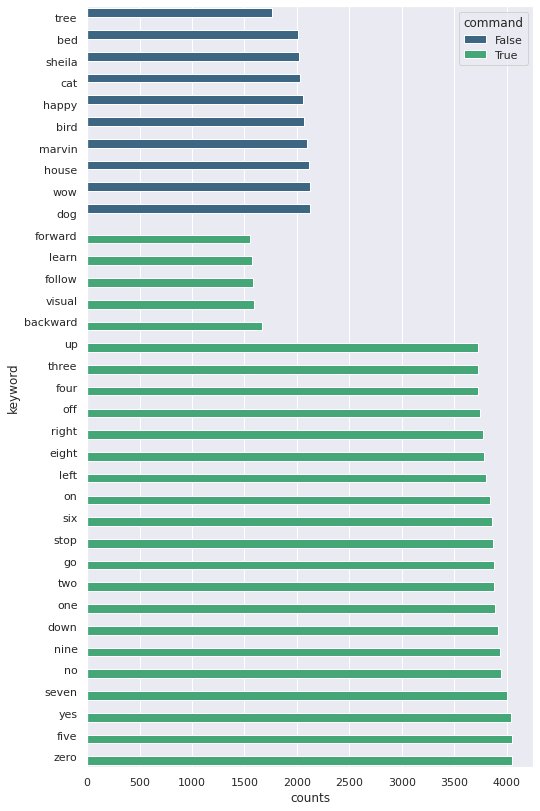

In [107]:
sns.barplot(
    x="counts",
    y="keyword",
    hue="command",
    palette="viridis",
    data=sc.sort_values(["command", "counts"]),
)
plt.gcf().set_size_inches(8, 14)

In [8]:
keywords = set([k for (k, _, _) in speech_commands_dataset])

In [65]:
def clean_and_filter(keyword_set: Set[str], sentence: str) -> List[str]:
    tokens = nltk.word_tokenize(sentence)
    words = [word.lower() for word in tokens if word.isalpha()]
    return list(filter(lambda w: w in keyword_set, words))

def update_counts(counts: Dict[str, int], words: List[str]) -> None:
    for w in words:
        counts[w] += 1

def count_occurences(keyword_set, tsv):
    df = pd.read_csv(tsv, sep="\t")
    
    # there are NaNs in test.tsv['sentence']
    # https://stackoverflow.com/a/50533971
    df.sentence.dropna(inplace=True)
    
    print("Dataset:", tsv)
    print("Number of mp3s:", df.shape[0])
    
    #def tokenize_by_keyword(row):
    #    return clean_and_filter(keyword_set, row.sentence)

    counts = {k:0 for k in keyword_set}
    
    # TODO(MMAZ) inefficient
    df['keywords'] = df.sentence.apply(functools.partial(clean_and_filter, keyword_set))
    
    df.keywords.dropna(inplace=True)
    usable = df.keywords.transform(len)
    print("mp3s containing speechcommands keywords", usable[usable > 0].shape[0])
    
    _ = [update_counts(counts, tokens) for tokens in df.keywords]
    
    return counts

In [10]:
def plot_counts(counts, title):
    df = pd.DataFrame(list(counts.items()), columns=["keyword", "counts"])
    sns.barplot(x="counts", y="keyword", data=df).set_title(title)
    plt.gcf().set_size_inches(10, 15)

In [74]:
def plot_uncommon(
    counts, title, common=["on", "one", "two", "three", "four", "no", "up", "down"]
):
    """view counts without the most common words"""
    without = {k: v for k, v in counts.items() if k not in common}
    plot_counts(without, title)

## Common Voice Analysis

Data is split across these TSVs in Common Voice. 

In [11]:
# TSVs
common_voice = "../mozilla_common_voice/"
TRAIN = common_voice + "train.tsv"
DEV = common_voice + "dev.tsv"
TEST = common_voice + "test.tsv"
VAL = common_voice + "validated.tsv"
# ignoring {other, invalidated}

Dataset: ../mozilla_common_voice/train.tsv
Number of mp3s: 232975
mp3s containing speechcommands keywords 44917


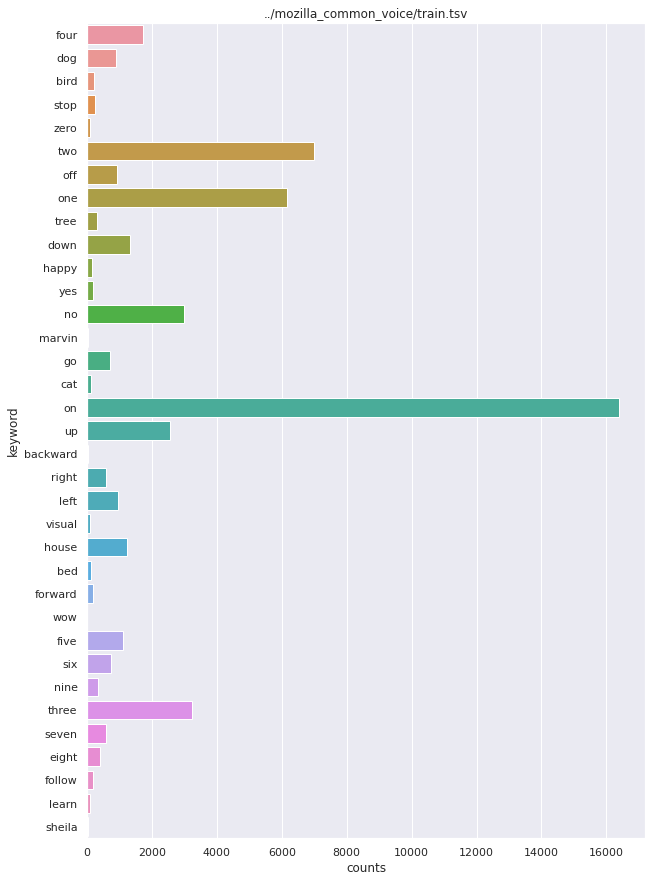

In [69]:
train_counts = count_occurences(keywords, TRAIN)
plot_counts(train_counts, TRAIN)

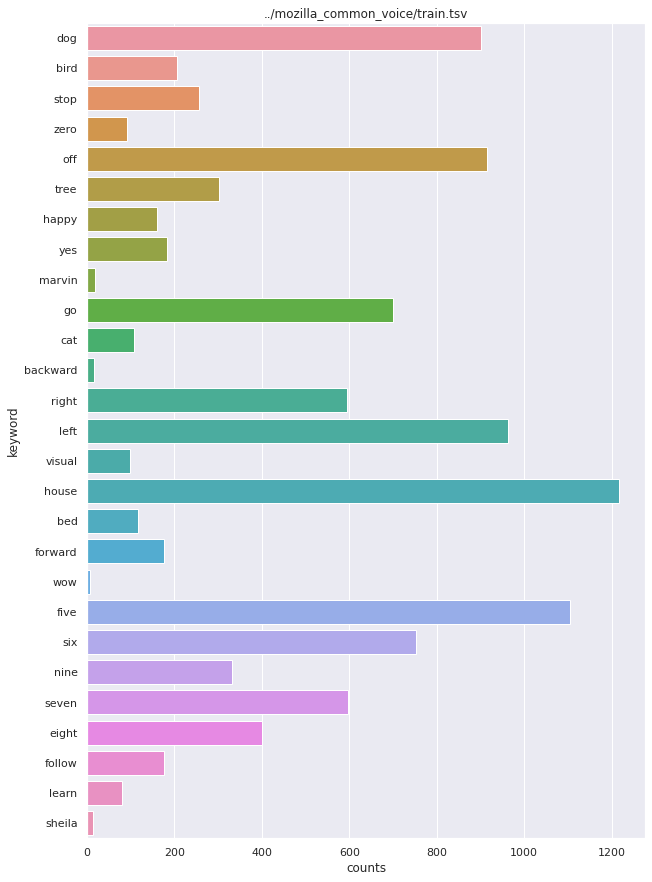

In [75]:
plot_uncommon(train_counts, TRAIN)

Dataset: ../mozilla_common_voice/dev.tsv
Number of mp3s: 15531
mp3s containing speechcommands keywords 2830


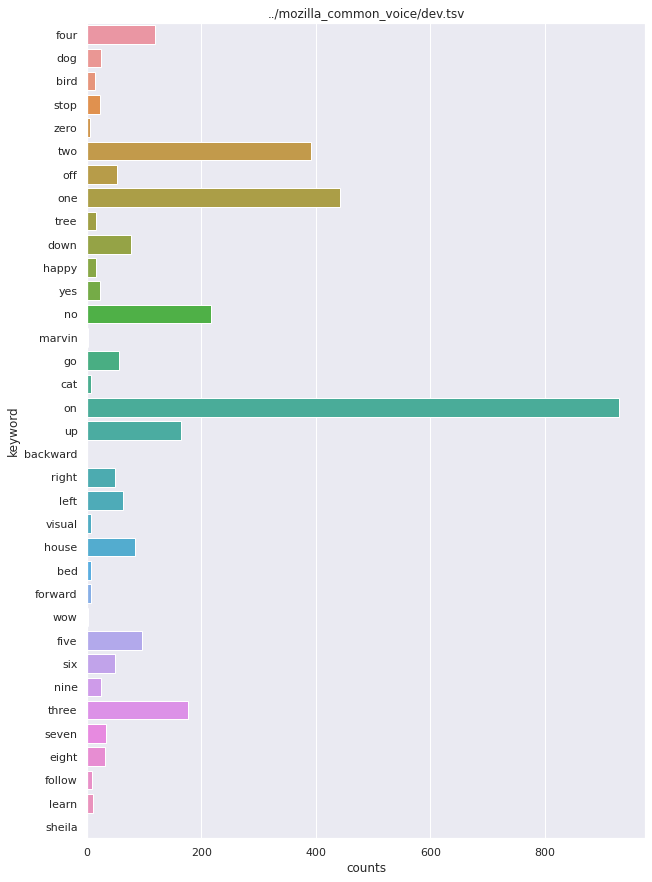

In [76]:
dev_counts = count_occurences(keywords, DEV)
plot_counts(dev_counts, DEV)

Dataset: ../mozilla_common_voice/test.tsv
Number of mp3s: 15531
mp3s containing speechcommands keywords 3121


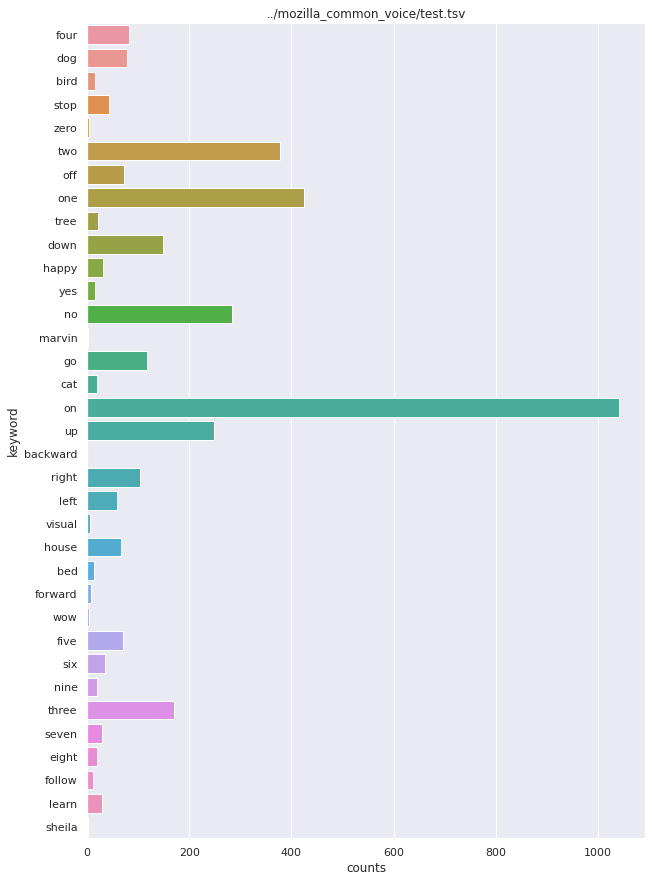

In [77]:
test_counts = count_occurences(keywords, TEST)
plot_counts(test_counts, TEST)

In [52]:
# sidenote: there's a bad row in test.tsv:
df = pd.read_csv(TEST, sep="\t")
df[df.sentence.isna()]

,client_id,path,sentence,up_votes,down_votes,age,gender,accent
458,2a23c7be6a9665215496be5e793ad9a334721810990672...,common_voice_en_16759015.mp3,NaN,2,0,NaN,NaN,NaN


### `validated.tsv`

Note that `validated.tsv` is much larger than all of the splits (train/dev/test) combined. [See here for details:](https://discourse.mozilla.org/t/why-train-tsv-includes-a-few-files-just-3-of-validated-set/36471/6)

> The reason is that many sentences were read multiple times by different people, and in machine learning you do not want a training set to be biased or it will result in a biased model trained from the biased training data set. So repeats of read sentences, even though validated, were removed when validated.tsv was distributed among train.tsv, dev.tsv, and test.tsv.

/home/mark/miniconda3/envs/deepspeech/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Dataset: ../mozilla_common_voice/validated.tsv
Number of mp3s: 854444
mp3s containing speechcommands keywords 162362


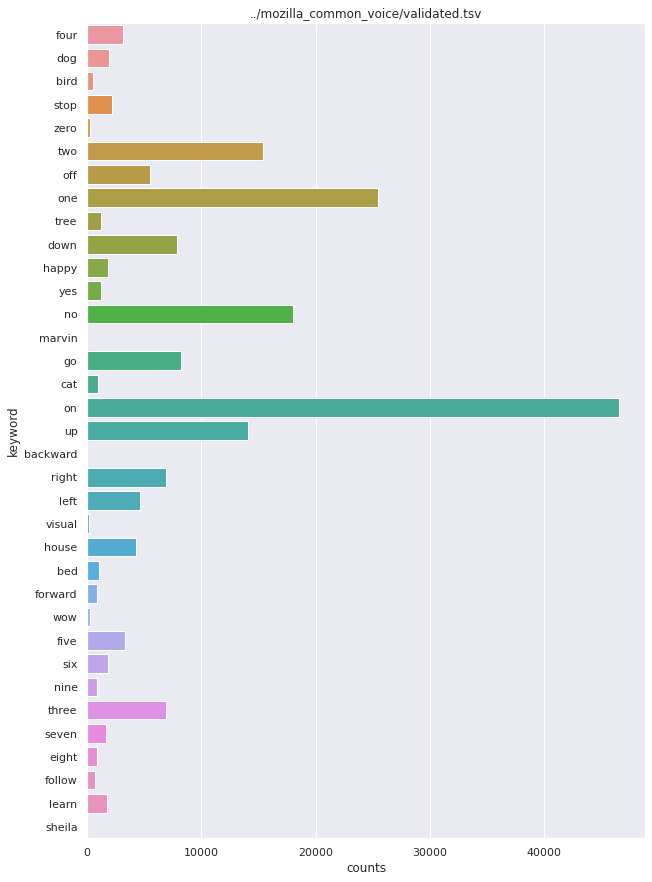

In [78]:
val_counts = count_occurences(keywords, VAL)
plot_counts(val_counts, VAL)

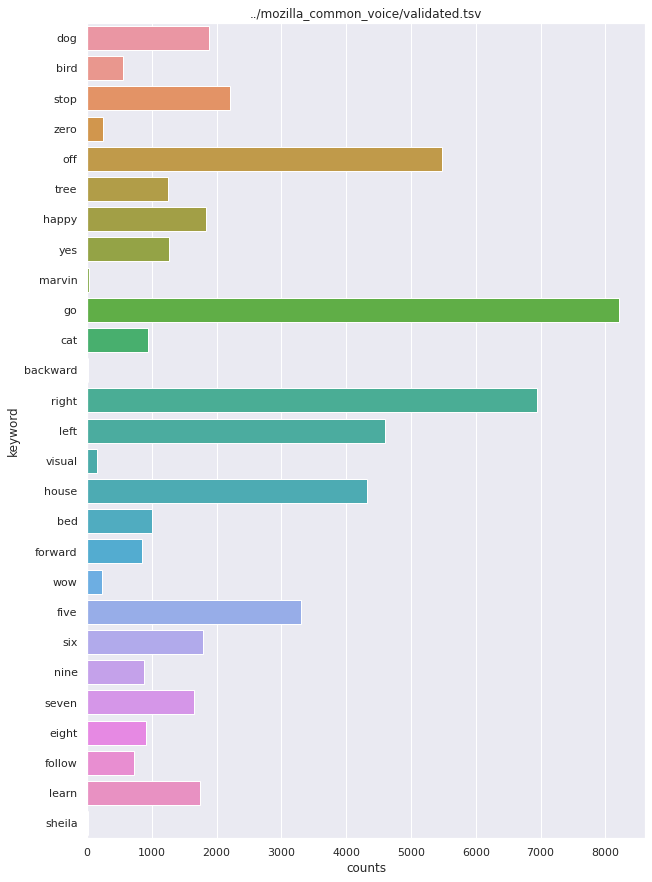

In [79]:
plot_uncommon(val_counts, VAL)

## Comparing the Common Voice data in aggregate with Speech Commands

In [141]:
train_df = pd.DataFrame(train_counts.items(), columns=["keyword", "train"])
dev_df = pd.DataFrame(dev_counts.items(), columns=["keyword", "dev"])
test_df = pd.DataFrame(test_counts.items(), columns=["keyword", "test"])
val_df = pd.DataFrame(val_counts.items(), columns=["keyword", "val"])

Combining train/dev/test

In [142]:
comparison = pd.concat([train_df.keyword, sc.counts, train_df.train, dev_df.dev, test_df.test, val_df.val], axis=1, sort=False)
comparison.rename(columns={"counts":"speech_commands"},inplace=True)
comparison.insert(5, column="train/dev/test", value=train_df.train + dev_df.dev + test_df.test)

In [143]:
comparison

,keyword,speech_commands,train,dev,test,train/dev/test,val
0,four,1664,1726,118,83,1927,3176
1,dog,2014,901,24,79,1004,1882
2,bird,2064,206,13,16,235,559
3,stop,2031,257,22,42,321,2211
4,zero,2128,91,5,4,100,240
5,two,3917,6996,392,378,7766,15420
6,off,3787,914,52,73,1039,5475
7,one,4052,6149,443,424,7016,25485
8,tree,1579,302,16,21,339,1251
9,down,1557,1317,76,149,1542,7916


In [186]:
# TODO(MMAZ) this is a hacky/lazy way to rearrange for visualization
# speech_commands counts
s2 = sc[['keyword', 'counts']].copy()
s2['source'] = "speech_commands"
# train/dev/test counts
tdt = comparison[['keyword', 'train/dev/test']].copy()
tdt.rename(columns={"train/dev/test":"counts"},inplace=True)
tdt['source'] = 'train/dev/test'
# validation counts
v = comparison[['keyword', 'val']].copy()
v.rename(columns={"val":"counts"},inplace=True)
v['source']="validation"
# sandwich it together:
sc_vs_tdt = pd.concat([s2,tdt])
total = pd.concat([s2,tdt,v])

### Word frequency in Speech Commands vs Common Voice Train/Dev/Test

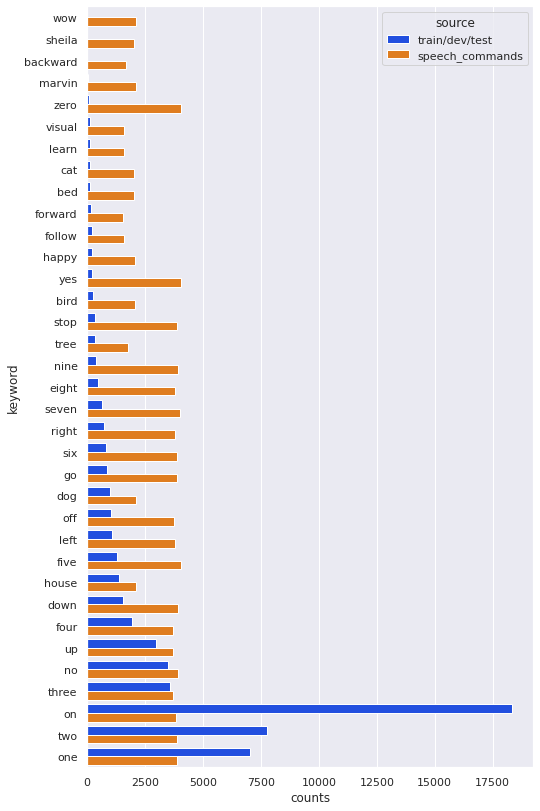

In [188]:
fig, ax = plt.subplots()
p = sns.barplot(
    x="counts",
    y="keyword",
    hue="source",
    palette="bright",
    data=sc_vs_tdt.sort_values(["counts"]),
    ax=ax
)
fig.set_size_inches(8, 14)
#p.set(xlim=(0,5000));

### Word frequency in Speech Commands vs Common Voice Train/Dev/Test vs Common Voice Validation

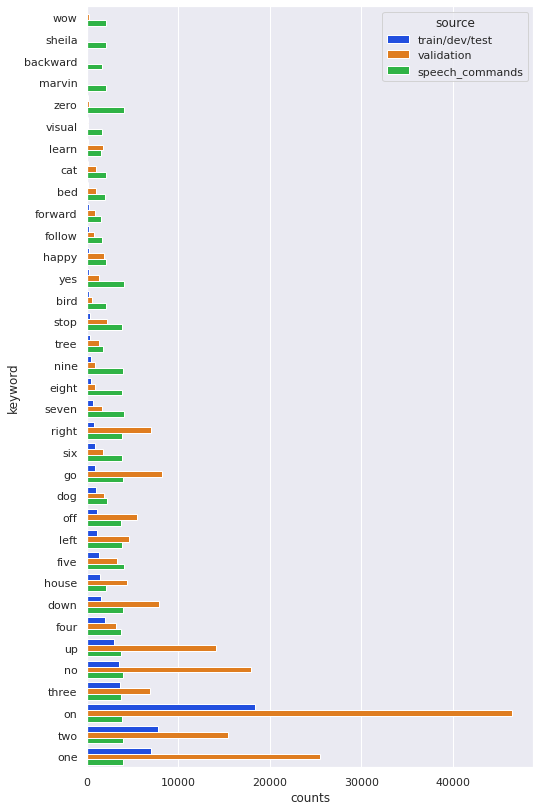

In [192]:
fig, ax = plt.subplots()
p = sns.barplot(
    x="counts",
    y="keyword",
    hue="source",
    palette="bright",
    data=total.sort_values(["counts"]),
    ax=ax
)
fig.set_size_inches(8, 14)

truncating at 5000:

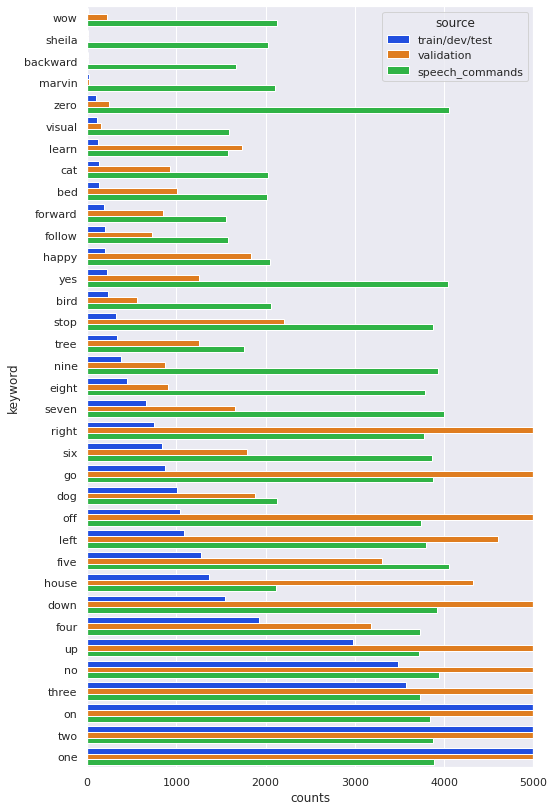

In [191]:
fig, ax = plt.subplots()
p = sns.barplot(
    x="counts",
    y="keyword",
    hue="source",
    palette="bright",
    data=total.sort_values(["counts"]),
    ax=ax
)
fig.set_size_inches(8, 14)
p.set(xlim=(0,5000));

## Questions

### 1. Should we include homonyms?

* `one`, `won`
* `two`, `to`
* `four`, `for`
* `right`, `write`
* `eight`, `ate`

any others? `house` vs `how's`? (marginal)

**Note:** `to` and `for` are overwhelmingly common [stop words](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html) - they might cause training biases.

### 2. What about plurals/stems/posessives?

* `bed` vs `beds` (non-command word)
* `backward` vs `backwards`
* `stop` vs `stops`
* `right` vs `rights`
* `house` vs `houses` vs `house's`
* etc...


In [161]:
homonyms = set(["won", "write", "ate"])
homonyms_count = count_occurences(homonyms, TRAIN)

Dataset: ../mozilla_common_voice/en/train.tsv
Number of mp3s: 232975
Sentences with speechcommands keywords 1059


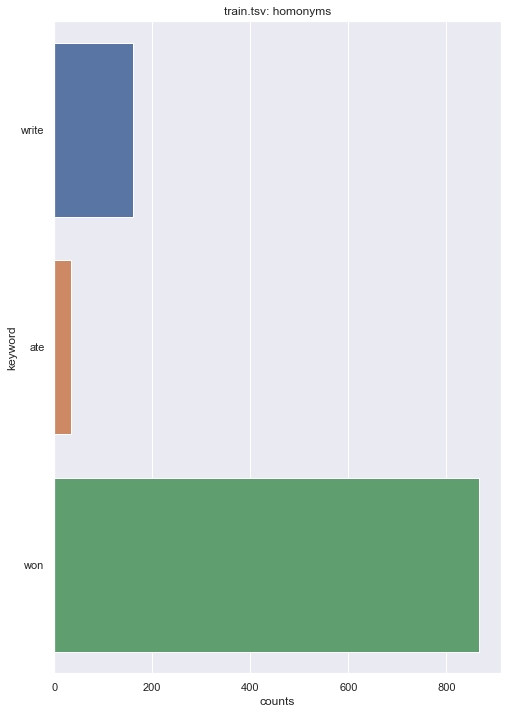

In [162]:
plot_counts(homonyms_count, "train.tsv: homonyms")

In [164]:
stopwords_count = count_occurences(set(["to", "for"]), TRAIN)

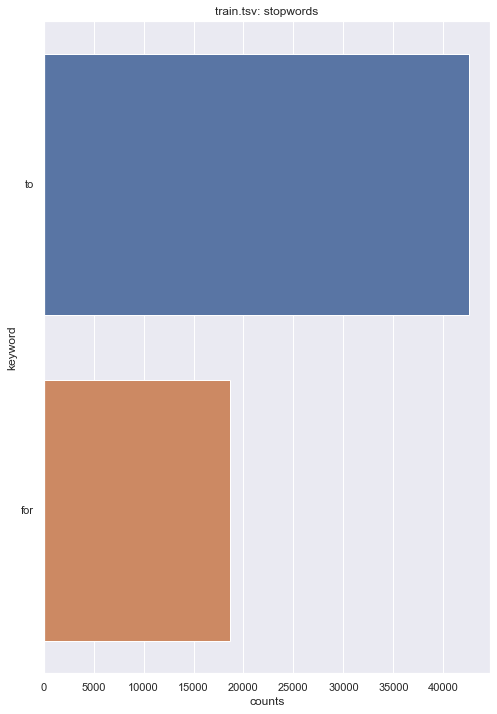

In [165]:
plot_counts(stopwords_count, "train.tsv: stopwords")